In [1]:
import numpy as np
import pandas as pd
import torch
from scipy.stats import random_correlation
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from tool import *
from data_generator import DataGenerator
device = 'cuda:1'

plt.rc('font', family='serif')


In [100]:
class NN_theo(nn.Module):
    def __init__(self, input_dim, init_basket, k):
        super(NN_theo, self).__init__()
        self.name = 'NN'
        self.units = init_basket.shape[1]
        init_basket = torch.as_tensor(init_basket, dtype=torch.float32)

        self.w = nn.Parameter(init_basket)
        nn.init.normal_(self.w)
        
        self.v = nn.Parameter(
            torch.normal(mean=0.,
                         std=math.sqrt(2 / (1 + self.units)),
                         size=(self.units, 1)))
        self.k=k
        self.activation = F.relu
        self.std_X = float(2)

    def forward(self, x):
       
        x = self.activation(torch.matmul(x, self.w) - self.k)
        
        x = torch.matmul(x, self.v)
        return x

# $d = 1$ case

In [101]:
k = 1
DC_dict = {
    'pay_func': lambda X: F.relu(torch.sum(torch.abs(X), dim = 1, keepdims = True) - k),
    'lb1': -5.,
    'ub1': 5.,
    'lb2': -3.,
    'ub2': 3.,
}
payoff_dict = {
               'DC': DC_dict,
               }

In [102]:
dat = DataGenerator(payoff_dict, 'DC', 1)

X_train, y_train = dat.sample_uniform(10000)

X_test,y_test = dat.sample_uniform(50000)
idx = np.arange(0, X_train.shape[0])
np.random.shuffle(idx)
X_train, y_train = X_train[idx], y_train[idx]

b_inf = float(k/(X_train).norm(dim = 1).max())
b_sup = 3.    
b_inf_l1 = k/(X_train).max()

## without regularization

  0%|          | 0/2000 [00:00<?, ?it/s]

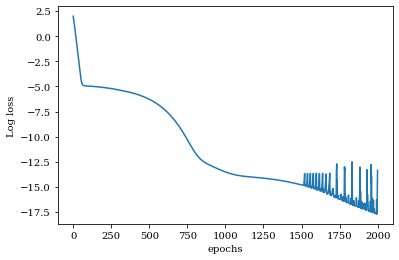

Best error = 2.0820094093210173e-08


In [103]:
init_point = np.random.rand(10, 1) * (b_sup - b_inf) + b_inf

model = NN_theo(1, torch.tensor(init_point).T, k).to(device)

fit_net(model, X_train, y_train, device, 2000, 0.001, None, 0.000)



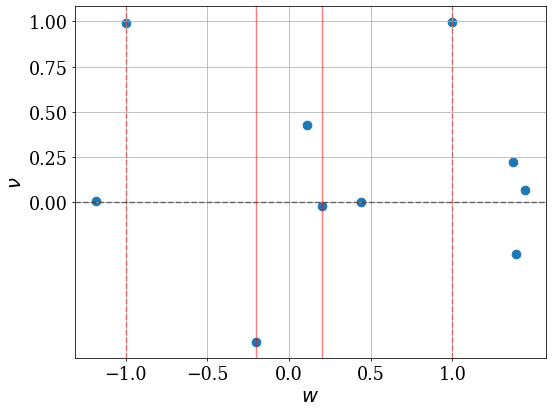

In [104]:
weight = np.concatenate([model.w.detach().T.cpu().numpy(), model.v.detach().cpu().numpy()], axis =1)

fig, ax = plt.subplots(figsize=(8,6), dpi = 70)

plt.axvline(x=-1, color='r', linestyle='--', alpha = 0.5)
plt.axvline(x=1, color='r', linestyle='--', alpha = 0.5)
plt.axhline(y=0, color='black', linestyle='--', alpha = 0.5)

plt.axvline(x=-k/X_train.max(), color='r', linestyle='-', alpha = 0.5)
plt.axvline(x=k/X_train.max(), color='r', linestyle='-', alpha = 0.5)
plt.scatter(weight[:,0], weight[:,1], alpha = 1, s = 80 )

plt.xlabel(r'$w$', fontsize = 20)
plt.ylabel(r'$\nu$', fontsize = 20)
plt.xticks(np.arange(-1, 1.01, step=0.5), fontsize = 18)
plt.yticks(np.arange(0, 1.01, step=0.25), fontsize = 18)
ax.grid(True)
fig.tight_layout()
plt.savefig('fig/d1_nonregu.pdf')

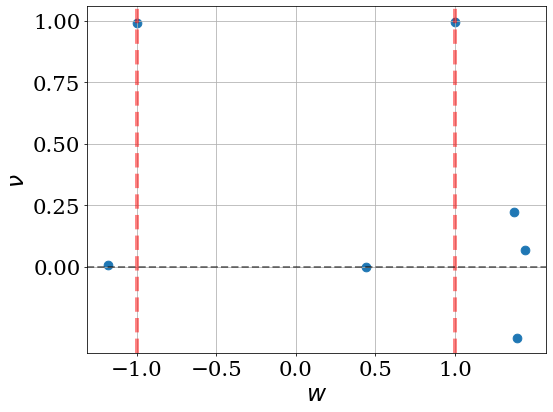

In [105]:
weight = weight[(weight[:,0]>float(k/X_train.max())) |(weight[:,0]<float(-k/X_train.max()))]

fig, ax = plt.subplots(figsize=(8,6), dpi = 70)


#plt.axvline(x=-k/X_train.max(), color='r', linestyle='-', alpha = 0.5)
#plt.axvline(x=k/X_train.max(), color='r', linestyle='-', alpha = 0.5)
plt.scatter(weight[:,0], weight[:,1], alpha = 1, s = 80 )

plt.axvline(x=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axhline(y=0, color='black', linestyle='--', alpha = 0.5, lw = 2)

plt.xlabel(r'$w$', fontsize = 24)
plt.ylabel(r'$\nu$', fontsize = 24)
plt.xticks(np.arange(-1, 1.01, step=0.5), fontsize = 22)
plt.yticks(np.arange(0, 1.01, step=0.25), fontsize = 22)
ax.grid(True)
fig.tight_layout()
plt.savefig('fig/d1_nonregu_short.pdf')

## with regularization

In [ ]:
init_point = np.random.rand(10, 1) * (b_sup - b_inf) + b_inf

model = NN_theo(1, torch.tensor(init_point).T, k).to(device)

fit_net(model, X_train, y_train, device, 2000, 0.001, None, 0.001)



  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
weight = np.concatenate([model.w.detach().T.cpu().numpy(), model.v.detach().cpu().numpy()], axis =1)

fig, ax = plt.subplots(figsize=(8,6), dpi = 70)

plt.axvline(x=-1, color='r', linestyle='--', alpha = 0.5)
plt.axvline(x=1, color='r', linestyle='--', alpha = 0.5)
plt.axhline(y=0, color='black', linestyle='--', alpha = 0.5)

plt.axvline(x=-k/X_train.max(), color='r', linestyle='-', alpha = 0.5)
plt.axvline(x=k/X_train.max(), color='r', linestyle='-', alpha = 0.5)
plt.scatter(weight[:,0], weight[:,1], alpha = 1, s = 80 )

plt.xlabel(r'$w$', fontsize = 20)
plt.ylabel(r'$\nu$', fontsize = 20)
plt.xticks(np.arange(-1, 1.01, step=0.5), fontsize = 18)
plt.yticks(np.arange(0, 1.01, step=0.25), fontsize = 18)
ax.grid(True)
fig.tight_layout()
plt.savefig('fig/d1_regu.pdf')

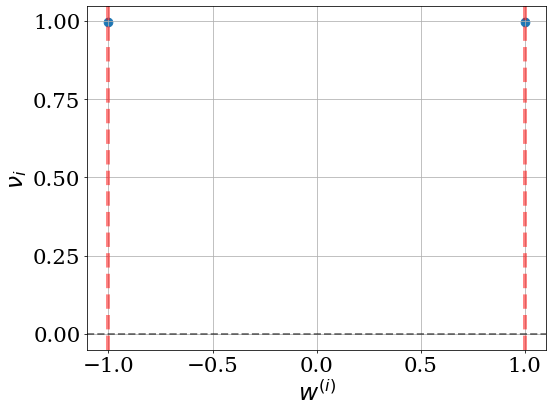

In [29]:
weight = weight[(weight[:,0]>float(k/X_train.max())) |(weight[:,0]<float(-k/X_train.max()))]

fig, ax = plt.subplots(figsize=(8,6), dpi = 70)

#plt.axvline(x=-k/X_train.max(), color='r', linestyle='-', alpha = 0.5)
#plt.axvline(x=k/X_train.max(), color='r', linestyle='-', alpha = 0.5)
plt.scatter(weight[:,0], weight[:,1], alpha = 1, s = 80 )

plt.axvline(x=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axhline(y=0, color='black', linestyle='--', alpha = 0.5, lw = 2)

plt.xlabel(r'$w^{(i)}$', fontsize = 24)
plt.ylabel(r'$\nu_i$', fontsize = 24)
plt.xticks(np.arange(-1, 1.01, step=0.5), fontsize = 22)
plt.yticks(np.arange(0, 1.01, step=0.25), fontsize = 22)
ax.grid(True)
fig.tight_layout()
plt.savefig('fig/d1_regu_short.pdf')

# $d=2$ case

## $k = 1$

In [30]:
k = 1.
DC_dict = {
    'pay_func': lambda X: F.relu(torch.sum(torch.abs(X), dim = 1, keepdims = True) - k),
    'lb2': -2.,
    'ub2': 2.,
}
payoff_dict = {
               'DC': DC_dict,
               }

In [31]:
dat = DataGenerator(payoff_dict, 'DC', 2)

X_train, y_train = dat.sample_uniform(10000)

X_test,y_test = dat.sample_uniform(50000)
idx = np.arange(0, X_train.shape[0])
np.random.shuffle(idx)
X_train,y_train = X_train[idx], y_train[idx]


b_inf = float(k/(X_train).norm(dim = 1).max())
b_sup = 3.    
b_inf_l1 = k/(X_train).max()

  0%|          | 0/3000 [00:00<?, ?it/s]

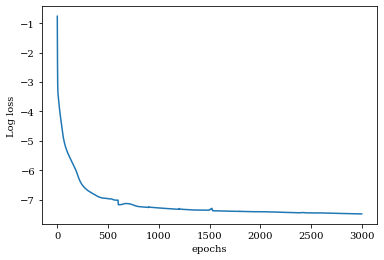

Best error = 0.0005641401512548327


In [32]:
l = 50
init_point = sphere_uniform(l, 2)
r_point = np.random.uniform(b_inf, b_sup, len(init_point))
init_point *= r_point.reshape(-1, 1)

model = NN_theo(2, torch.tensor(init_point).T, k).to(device)
fit_net(
    model,
    X_train,
    y_train,
    device,
    3000,
    0.005,
    None,
    0.0,
)

In [34]:
weight_nu =pd.DataFrame(torch.cat([model.w.T.cpu(),
                           model.v.cpu(),
                          torch.abs(model.v.grad).cpu()], dim = 1).detach().cpu().numpy())

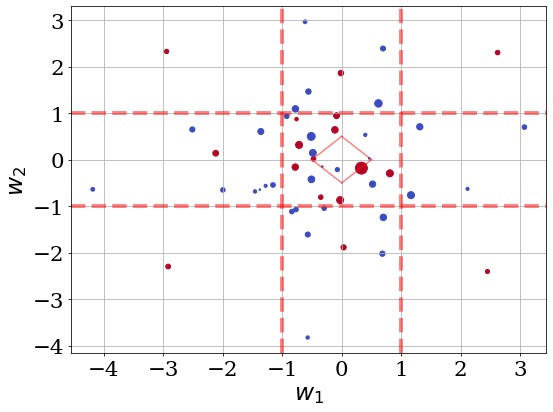

In [35]:
fig, ax = plt.subplots(figsize=(8,6), dpi = 70)
plt.axhline(y=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axhline(y=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
ax.plot((0,b_inf_l1), (b_inf_l1,0), c = 'r', alpha = 0.5)
ax.plot((0,b_inf_l1), (-b_inf_l1,0), c = 'r', alpha = 0.5)
ax.plot((0,-b_inf_l1), (b_inf_l1,0), c = 'r', alpha = 0.5)
ax.plot((0,-b_inf_l1), (-b_inf_l1,0), c = 'r', alpha = 0.5)
sc = ax.scatter(weight_nu[0], weight_nu[1], 
           c=2*(weight_nu[2]>0)-1, s = np.abs(weight_nu[2])/ np.abs(weight_nu[2]).max()*150,
           cmap='coolwarm_r', alpha = 1 , zorder = 1)
sc.set_clim(-weight_nu[2].max(),weight_nu[2].max())
#cb = plt.colorbar(sc)
#cb.ticks( fontsize = 12)

plt.xlabel(r'$w_1$', fontsize = 24)
plt.ylabel(r'$w_2$', fontsize = 24)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
ax.grid(True)
fig.tight_layout()
plt.savefig('fig/d2_1_nonregu.pdf')
plt.show()

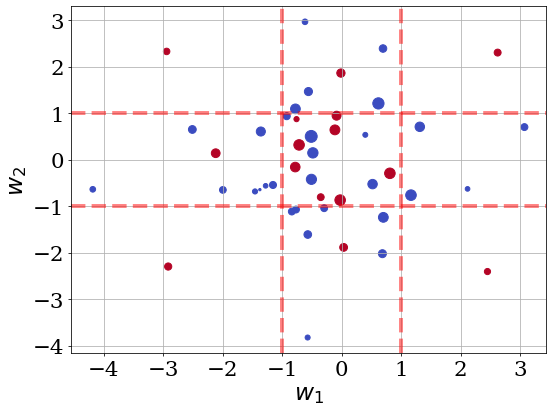

In [36]:
norm_w = np.linalg.norm(np.array(weight_nu.iloc[:,0:2]), axis = 1)
weight_nu = weight_nu[(norm_w>float(k/X_train.max())) |(norm_w<float(-k/X_train.max()))]
fig, ax = plt.subplots(figsize=(8,6), dpi = 70)
plt.axhline(y=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axhline(y=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
#ax.plot((0,b_inf_l1), (b_inf_l1,0), c = 'r', alpha = 0.5)
#ax.plot((0,b_inf_l1), (-b_inf_l1,0), c = 'r', alpha = 0.5)
#ax.plot((0,-b_inf_l1), (b_inf_l1,0), c = 'r', alpha = 0.5)
#ax.plot((0,-b_inf_l1), (-b_inf_l1,0), c = 'r', alpha = 0.5)
sc = ax.scatter(weight_nu[0], weight_nu[1], 
           c=2*(weight_nu[2]>0)-1, s = np.abs(weight_nu[2])/ np.abs(weight_nu[2]).max()*150,
           cmap='coolwarm_r', alpha = 1 , zorder = 1)
sc.set_clim(-weight_nu[2].max(),weight_nu[2].max())
#cb = plt.colorbar(sc)
#cb.ticks( fontsize = 12)

plt.xlabel(r'$w_1$', fontsize = 24)
plt.ylabel(r'$w_2$', fontsize = 24)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
ax.grid(True)
fig.tight_layout()
plt.savefig('fig/d2_1_nonregu_short.pdf')
plt.show()

  0%|          | 0/3000 [00:00<?, ?it/s]

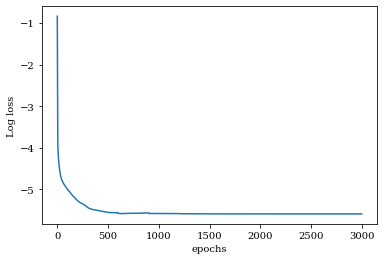

Best error = 0.00372176431119442


In [37]:
l = 50
init_point = sphere_uniform(l, 2)
r_point = np.random.uniform(b_inf, b_sup, len(init_point))
init_point *= r_point.reshape(-1, 1)

model = NN_theo(2, torch.tensor(init_point).T, k).to(device)
fit_net(
    model,
    X_train,
    y_train,
    device,
    3000,
    0.005,
    None,
    0.001,
)

In [38]:
weight_nu =pd.DataFrame(torch.cat([model.w.T.cpu(),
                           model.v.cpu(),
                          torch.abs(model.v.grad).cpu()], dim = 1).detach().cpu().numpy())

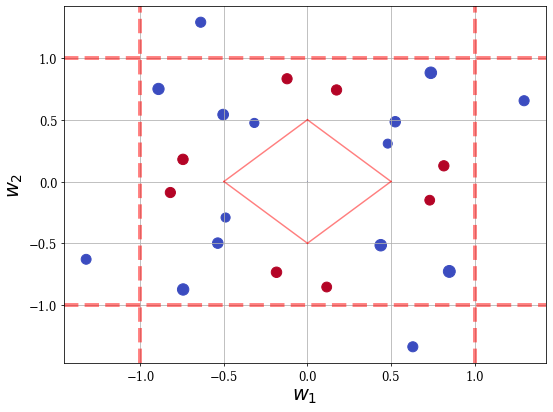

In [39]:
fig, ax = plt.subplots(figsize=(8,6), dpi = 70)
plt.axhline(y=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axhline(y=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
ax.plot((0,b_inf_l1), (b_inf_l1,0), c = 'r', alpha = 0.5)
ax.plot((0,b_inf_l1), (-b_inf_l1,0), c = 'r', alpha = 0.5)
ax.plot((0,-b_inf_l1), (b_inf_l1,0), c = 'r', alpha = 0.5)
ax.plot((0,-b_inf_l1), (-b_inf_l1,0), c = 'r', alpha = 0.5)
sc = ax.scatter(weight_nu[0], weight_nu[1], 
           c=2*(weight_nu[2]>0)-1, s = np.abs(weight_nu[2])/ np.abs(weight_nu[2]).max()*150,
           cmap='coolwarm_r', alpha = 1 , zorder = 1)
sc.set_clim(-weight_nu[2].max(),weight_nu[2].max())
#cb = plt.colorbar(sc)
#cb.ticks( fontsize = 12)

plt.xlabel(r'$w_1$', fontsize = 20)
plt.ylabel(r'$w_2$', fontsize = 20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax.grid(True)
fig.tight_layout()
plt.savefig('fig/d2_1_regu.pdf')
plt.show()

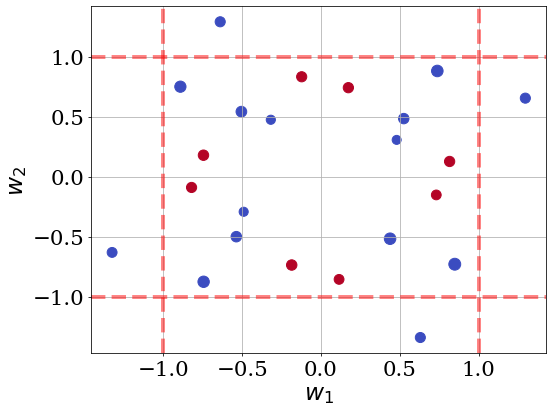

In [40]:
norm_w = np.linalg.norm(np.array(weight_nu.iloc[:,0:2]), axis = 1)
weight_nu = weight_nu[(norm_w>float(k/X_train.max())) |(norm_w<float(-k/X_train.max()))]

fig, ax = plt.subplots(figsize=(8,6), dpi = 70)
plt.axhline(y=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axhline(y=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=1, color='r', linestyle='--', alpha = 0.5, lw = 4)

sc = ax.scatter(weight_nu[0], weight_nu[1], 
           c=2*(weight_nu[2]>0)-1, s = np.abs(weight_nu[2])/ np.abs(weight_nu[2]).max()*150,
           cmap='coolwarm_r', alpha = 1 , zorder = 1)
sc.set_clim(-weight_nu[2].max(),weight_nu[2].max())
#cb = plt.colorbar(sc)
#cb.ticks( fontsize = 12)

plt.xlabel(r'$w_1$', fontsize = 24)
plt.ylabel(r'$w_2$', fontsize = 24)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
ax.grid(True)
fig.tight_layout()
plt.savefig('fig/d2_1_regu_short.pdf')
plt.show()

## $k = 1.5$

In [41]:
k = 1.5
DC_dict = {
    'pay_func': lambda X: F.relu(torch.sum(torch.abs(X), dim = 1, keepdims = True) - k),
    'lb2': -2.,
    'ub2': 2.,
}
payoff_dict = {
               'DC': DC_dict,
               }

In [42]:
dat = DataGenerator(payoff_dict, 'DC', 2)

X_train, y_train = dat.sample_uniform(10000)

X_test,y_test = dat.sample_uniform(50000)
idx = np.arange(0, X_train.shape[0])
np.random.shuffle(idx)
X_train,y_train = X_train[idx], y_train[idx]


b_inf = float(k/(X_train).norm(dim = 1).max())
b_sup = 3.    
b_inf_l1 = k/(X_train).max()

  0%|          | 0/3000 [00:00<?, ?it/s]

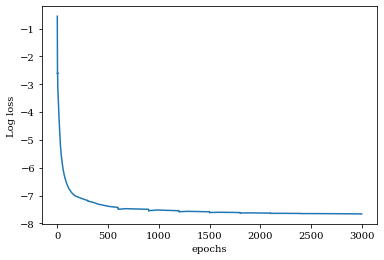

Best error = 0.00047213229117915034


In [43]:
l = 50
init_point = sphere_uniform(l, 2)
r_point = np.random.uniform(b_inf, b_sup, len(init_point))
init_point *= r_point.reshape(-1, 1)

model = NN_theo(2, torch.tensor(init_point).T, k).to(device)
fit_net(
    model,
    X_train,
    y_train,
    device,
    3000,
    0.005,
    None,
    0.0,
)

In [44]:
weight_nu =pd.DataFrame(torch.cat([model.w.T.cpu(),
                           model.v.cpu(),
                          torch.abs(model.v.grad).cpu()], dim = 1).detach().cpu().numpy())

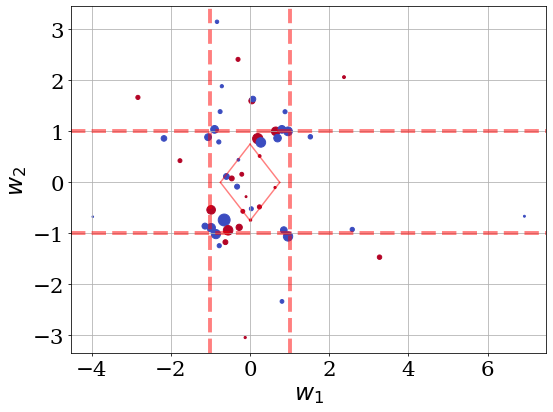

In [45]:
fig, ax = plt.subplots(figsize=(8,6), dpi = 70)
plt.axhline(y=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axhline(y=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
ax.plot((0,b_inf_l1), (b_inf_l1,0), c = 'r', alpha = 0.5)
ax.plot((0,b_inf_l1), (-b_inf_l1,0), c = 'r', alpha = 0.5)
ax.plot((0,-b_inf_l1), (b_inf_l1,0), c = 'r', alpha = 0.5)
ax.plot((0,-b_inf_l1), (-b_inf_l1,0), c = 'r', alpha = 0.5)
sc = ax.scatter(weight_nu[0], weight_nu[1], 
           c=2*(weight_nu[2]>0)-1, s = np.abs(weight_nu[2])/ np.abs(weight_nu[2]).max()*150,
           cmap='coolwarm_r', alpha = 1 , zorder = 1)
sc.set_clim(-weight_nu[2].max(),weight_nu[2].max())
#cb = plt.colorbar(sc)
#cb.ticks( fontsize = 12)

plt.xlabel(r'$w_1$', fontsize = 24)
plt.ylabel(r'$w_2$', fontsize = 24)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
ax.grid(True)
fig.tight_layout()
plt.savefig('fig/d2_1.5_nonregu.pdf')
plt.show()

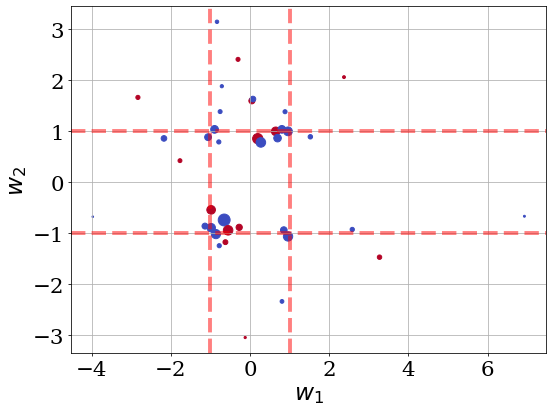

In [46]:
norm_w = np.linalg.norm(np.array(weight_nu.iloc[:,0:2]), axis = 1)
weight_nu = weight_nu[(norm_w>float(k/X_train.max())) |(norm_w<float(-k/X_train.max()))]
fig, ax = plt.subplots(figsize=(8,6), dpi = 70)
plt.axhline(y=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axhline(y=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
#ax.plot((0,b_inf_l1), (b_inf_l1,0), c = 'r', alpha = 0.5)
#ax.plot((0,b_inf_l1), (-b_inf_l1,0), c = 'r', alpha = 0.5)
#ax.plot((0,-b_inf_l1), (b_inf_l1,0), c = 'r', alpha = 0.5)
#ax.plot((0,-b_inf_l1), (-b_inf_l1,0), c = 'r', alpha = 0.5)
sc = ax.scatter(weight_nu[0], weight_nu[1], 
           c=2*(weight_nu[2]>0)-1, s = np.abs(weight_nu[2])/ np.abs(weight_nu[2]).max()*150,
           cmap='coolwarm_r', alpha = 1 , zorder = 1)
sc.set_clim(-weight_nu[2].max(),weight_nu[2].max())
#cb = plt.colorbar(sc)
#cb.ticks( fontsize = 12)

plt.xlabel(r'$w_1$', fontsize = 24)
plt.ylabel(r'$w_2$', fontsize = 24)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
ax.grid(True)
fig.tight_layout()
plt.savefig('fig/d2_1.5_nonregu_short.pdf')
plt.show()

  0%|          | 0/3000 [00:00<?, ?it/s]

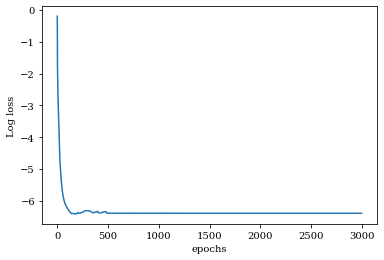

Best error = 0.0016375296982005239


In [47]:
l = 50
init_point = sphere_uniform(l, 2)
r_point = np.random.uniform(b_inf, b_sup, len(init_point))
init_point *= r_point.reshape(-1, 1)

model = NN_theo(2, torch.tensor(init_point).T, k).to(device)
fit_net(
    model,
    X_train,
    y_train,
    device,
    3000,
    0.005,
    None,
    0.001,
)

In [48]:
weight_nu =pd.DataFrame(torch.cat([model.w.T.cpu(),
                           model.v.cpu(),
                          torch.abs(model.v.grad).cpu()], dim = 1).detach().cpu().numpy())

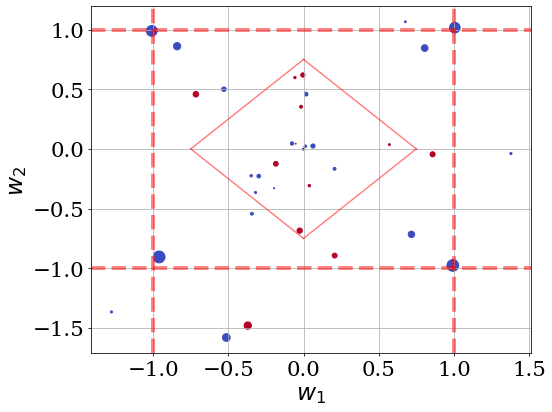

In [49]:
fig, ax = plt.subplots(figsize=(8,6), dpi = 70)
plt.axhline(y=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axhline(y=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
ax.plot((0,b_inf_l1), (b_inf_l1,0), c = 'r', alpha = 0.5)
ax.plot((0,b_inf_l1), (-b_inf_l1,0), c = 'r', alpha = 0.5)
ax.plot((0,-b_inf_l1), (b_inf_l1,0), c = 'r', alpha = 0.5)
ax.plot((0,-b_inf_l1), (-b_inf_l1,0), c = 'r', alpha = 0.5)
sc = ax.scatter(weight_nu[0], weight_nu[1], 
           c=2*(weight_nu[2]>0)-1, s = np.abs(weight_nu[2])/ np.abs(weight_nu[2]).max()*150,
           cmap='coolwarm_r', alpha = 1 , zorder = 1)
sc.set_clim(-weight_nu[2].max(),weight_nu[2].max())
#cb = plt.colorbar(sc)
#cb.ticks( fontsize = 12)

plt.xlabel(r'$w_1$', fontsize = 24)
plt.ylabel(r'$w_2$', fontsize = 24)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
ax.grid(True)
fig.tight_layout()
plt.savefig('fig/d2_1.5_regu.pdf')
plt.show()

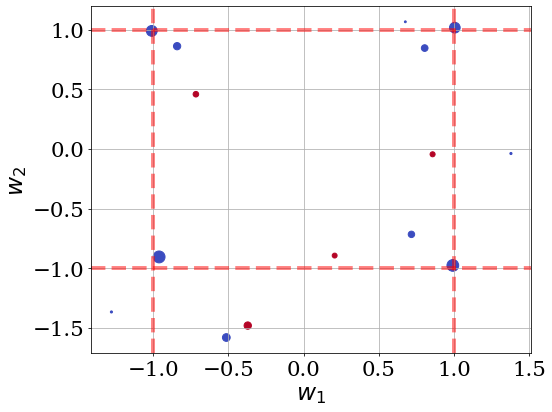

In [50]:
norm_w = np.linalg.norm(np.array(weight_nu.iloc[:,0:2]), axis = 1)
weight_nu = weight_nu[(norm_w>float(k/X_train.max())) |(norm_w<float(-k/X_train.max()))]

fig, ax = plt.subplots(figsize=(8,6), dpi = 70)
plt.axhline(y=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axhline(y=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=1, color='r', linestyle='--', alpha = 0.5, lw = 4)

sc = ax.scatter(weight_nu[0], weight_nu[1], 
           c=2*(weight_nu[2]>0)-1, s = np.abs(weight_nu[2])/ np.abs(weight_nu[2]).max()*150,
           cmap='coolwarm_r', alpha = 1 , zorder = 1)
sc.set_clim(-weight_nu[2].max(),weight_nu[2].max())
#cb = plt.colorbar(sc)
#cb.ticks( fontsize = 12)

plt.xlabel(r'$w_1$', fontsize = 24)
plt.ylabel(r'$w_2$', fontsize = 24)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
ax.grid(True)
fig.tight_layout()
plt.savefig('fig/d2_1.5_regu_short.pdf')
plt.show()

## $k = 2$

In [81]:
k = 2
DC_dict = {
    'pay_func': lambda X: F.relu(torch.sum(torch.abs(X), dim = 1, keepdims = True) - k),
    'lb2': -2.,
    'ub2': 2.,
}
payoff_dict = {
               'DC': DC_dict,
               }

In [82]:
dat = DataGenerator(payoff_dict, 'DC', 2)

X_train, y_train = dat.sample_uniform(10000)

X_test,y_test = dat.sample_uniform(50000)
idx = np.arange(0, X_train.shape[0])
np.random.shuffle(idx)
X_train,y_train = X_train[idx], y_train[idx]


b_inf = float(k/(X_train).norm(dim = 1).max())
b_sup = 3.    
b_inf_l1 = k/(X_train).max()

  0%|          | 0/3000 [00:00<?, ?it/s]

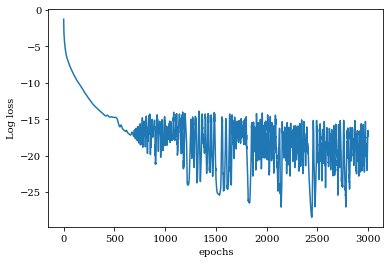

Best error = 4.655794521614409e-13


In [83]:
l = 50
init_point = sphere_uniform(l, 2)
r_point = np.random.uniform(b_inf, b_sup, len(init_point))
init_point *= r_point.reshape(-1, 1)

model = NN_theo(2, torch.tensor(init_point).T, k).to(device)
fit_net(
    model,
    X_train,
    y_train,
    device,
    3000,
    0.005,
    None,
    0.0,
)

In [84]:
weight_nu =pd.DataFrame(torch.cat([model.w.T.cpu(),
                           model.v.cpu(),
                          torch.abs(model.v.grad).cpu()], dim = 1).detach().cpu().numpy())

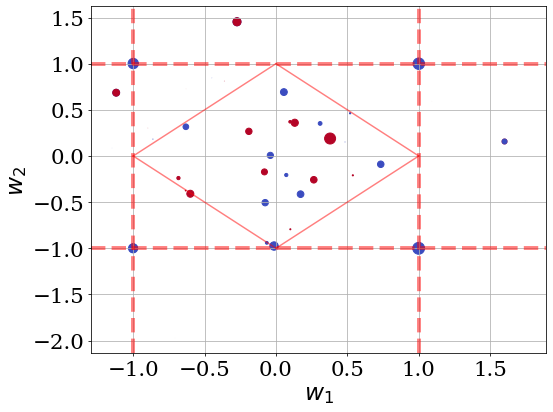

In [85]:
fig, ax = plt.subplots(figsize=(8,6), dpi = 70)
plt.axhline(y=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axhline(y=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
ax.plot((0,b_inf_l1), (b_inf_l1,0), c = 'r', alpha = 0.5)
ax.plot((0,b_inf_l1), (-b_inf_l1,0), c = 'r', alpha = 0.5)
ax.plot((0,-b_inf_l1), (b_inf_l1,0), c = 'r', alpha = 0.5)
ax.plot((0,-b_inf_l1), (-b_inf_l1,0), c = 'r', alpha = 0.5)
sc = ax.scatter(weight_nu[0], weight_nu[1], 
           c=2*(weight_nu[2]>0)-1, s = np.abs(weight_nu[2])/ np.abs(weight_nu[2]).max()*150,
           cmap='coolwarm_r', alpha = 1 , zorder = 1)
sc.set_clim(-weight_nu[2].max(),weight_nu[2].max())
#cb = plt.colorbar(sc)
#cb.ticks( fontsize = 12)

plt.xlabel(r'$w_1$', fontsize = 24)
plt.ylabel(r'$w_2$', fontsize = 24)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
ax.grid(True)
fig.tight_layout()
plt.savefig('fig/d2_2_nonregu.pdf')
plt.show()

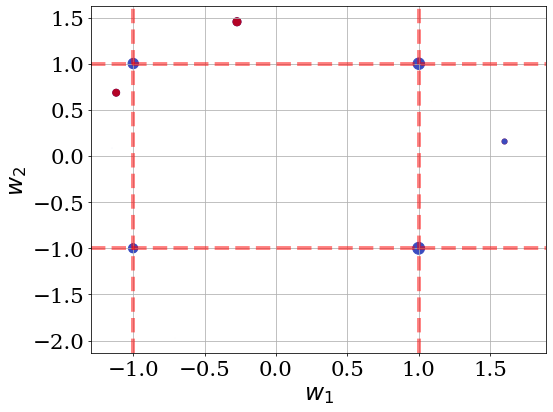

In [86]:
norm_w = np.linalg.norm(np.array(weight_nu.iloc[:,0:2]), axis = 1)
weight_nu = weight_nu[(norm_w>float(k/X_train.max())) |(norm_w<float(-k/X_train.max()))]
fig, ax = plt.subplots(figsize=(8,6), dpi = 70)
plt.axhline(y=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axhline(y=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
#ax.plot((0,b_inf_l1), (b_inf_l1,0), c = 'r', alpha = 0.5)
#ax.plot((0,b_inf_l1), (-b_inf_l1,0), c = 'r', alpha = 0.5)
#ax.plot((0,-b_inf_l1), (b_inf_l1,0), c = 'r', alpha = 0.5)
#ax.plot((0,-b_inf_l1), (-b_inf_l1,0), c = 'r', alpha = 0.5)
sc = ax.scatter(weight_nu[0], weight_nu[1], 
           c=2*(weight_nu[2]>0)-1, s = np.abs(weight_nu[2])/ np.abs(weight_nu[2]).max()*150,
           cmap='coolwarm_r', alpha = 1 , zorder = 1)
sc.set_clim(-weight_nu[2].max(),weight_nu[2].max())
#cb = plt.colorbar(sc)
#cb.ticks( fontsize = 12)

plt.xlabel(r'$w_1$', fontsize = 24)
plt.ylabel(r'$w_2$', fontsize = 24)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
ax.grid(True)
fig.tight_layout()
plt.savefig('fig/d2_2_nonregu_short.pdf')
plt.show()

  0%|          | 0/3000 [00:00<?, ?it/s]

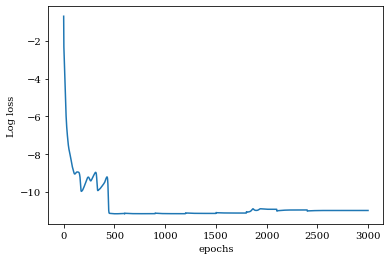

Best error = 1.4289551472757012e-05


In [87]:
l = 50
init_point = sphere_uniform(l, 2)
r_point = np.random.uniform(b_inf, b_sup, len(init_point))
init_point *= r_point.reshape(-1, 1)

model = NN_theo(2, torch.tensor(init_point).T, k).to(device)
fit_net(
    model,
    X_train,
    y_train,
    device,
    3000,
    0.005,
    None,
    0.001,
)

In [88]:
weight_nu =pd.DataFrame(torch.cat([model.w.T.cpu(),
                           model.v.cpu(),
                          torch.abs(model.v.grad).cpu()], dim = 1).detach().cpu().numpy())

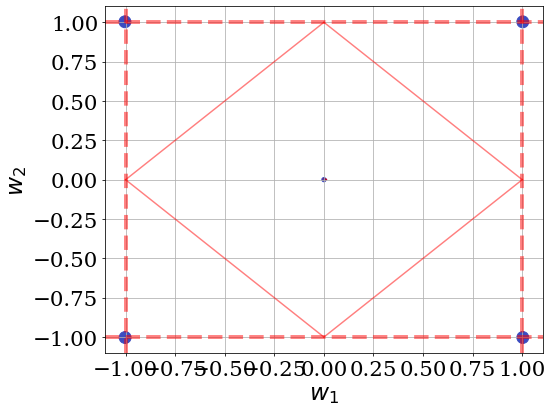

In [89]:
fig, ax = plt.subplots(figsize=(8,6), dpi = 70)
plt.axhline(y=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axhline(y=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
ax.plot((0,b_inf_l1), (b_inf_l1,0), c = 'r', alpha = 0.5)
ax.plot((0,b_inf_l1), (-b_inf_l1,0), c = 'r', alpha = 0.5)
ax.plot((0,-b_inf_l1), (b_inf_l1,0), c = 'r', alpha = 0.5)
ax.plot((0,-b_inf_l1), (-b_inf_l1,0), c = 'r', alpha = 0.5)
sc = ax.scatter(weight_nu[0], weight_nu[1], 
           c=2*(weight_nu[2]>0)-1, s = np.abs(weight_nu[2])/ np.abs(weight_nu[2]).max()*150,
           cmap='coolwarm_r', alpha = 1 , zorder = 1)
sc.set_clim(-weight_nu[2].max(),weight_nu[2].max())
#cb = plt.colorbar(sc)
#cb.ticks( fontsize = 12)

plt.xlabel(r'$w_1$', fontsize = 24)
plt.ylabel(r'$w_2$', fontsize = 24)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
ax.grid(True)
fig.tight_layout()
plt.savefig('fig/d2_2_regu.pdf')
plt.show()

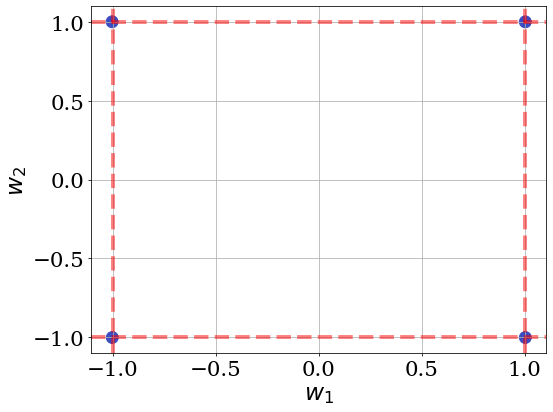

In [96]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

norm_w = np.linalg.norm(np.array(weight_nu.iloc[:,0:2]), axis = 1)
weight_nu = weight_nu[(norm_w>float(k/X_train.max())) |(norm_w<float(-k/X_train.max()))]

fig, ax = plt.subplots(figsize=(8,6), dpi = 70)
plt.axhline(y=1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axhline(y=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=-1, color='r', linestyle='--', alpha = 0.5, lw = 4)
plt.axvline(x=1, color='r', linestyle='--', alpha = 0.5, lw = 4)

sc = ax.scatter(weight_nu[0], weight_nu[1], 
           c=2*(weight_nu[2]>0)-1, s = np.abs(weight_nu[2])/ np.abs(weight_nu[2]).max()*150,
           cmap='coolwarm_r', alpha = 1 , zorder = 1)
sc.set_clim(-weight_nu[2].max(),weight_nu[2].max())
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
#cb = plt.colorbar(sc)
#cb.ticks( fontsize = 12)

plt.xlabel(r'$w_1$', fontsize = 24)
plt.ylabel(r'$w_2$', fontsize = 24)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
ax.grid(True)
fig.tight_layout()
plt.savefig('fig/d2_2_regu_short.pdf')
plt.show()